In [140]:
#py_geospatial env
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import process_ISIMIP as pISIMIP
import xesmf as xe
import dask

#segoe ui
plt.rcParams['font.family'] = 'Segoe UI'

#### Merge ISIMIP datasets for each scenario
Since ISIMIP data is downloaded in time chunks, these chunks need to be merged for each variable and scenario to make further analysis more convenient.  
For each GCM, this code block merges all the chunks for each variable and scenario to one dataset.  

This is only done once.

In [245]:
src_isimip = r"D:\VUB\_data\_isimip_3b"
models = list(map(str.upper, ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll']))
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']
variables = ['pr', 'tasmin', 'tasmax']

# Merge ISIMIP data chunks for each scenario
pISIMIP.merge_ISIMIP_datasets(src_isimip, models, scenarios, variables, verbose=False)

{('GFDL-ESM4', 'historical', 'pr'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'historical', 'tasmin'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'historical', 'tasmax'): {'files_found': 6, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp126', 'tasmax'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp370', 'tasmax'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'pr'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'tasmin'): {'files_found': 9, 'merged': False},
 ('GFDL-ESM4', 'ssp585', 'tasmax'): {'files_found': 9, 'merged': False},
 ('IPSL-CM6A-LR', 'historical', 'pr'): {'files_found': 6, 'merged': False},
 ('IPSL-CM6A-LR', 'historical', 'tasmin'): {'files_f

#### Import obs. data and compare with GCM data

In [267]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
tmax_EOBS = xr.open_dataset(f'{src}/tmax.nc')
tmin_EOBS = xr.open_dataset(f'{src}/tmin.nc')
pr_EOBS = xr.open_dataset(f'{src}/pre.nc')



isimip_data = {}

#Open the datasets for each model and scenario
for model in models:
    for scenario in scenarios:
        for variable in variables:
            file_path = f"{src_isimip}/{model}/{scenario}/{model}_{variable}_merged.nc"
            if glob.glob(file_path):
                isimip_data[(model, scenario, variable)] = xr.open_dataset(file_path)


In [4]:
#select historical tasmin for all models
tasmin_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'tasmin')] for model in models if (model, 'historical', 'tasmin') in isimip_data}
tasmax_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'tasmax')] for model in models if (model, 'historical', 'tasmax') in isimip_data}
pr_hist = {(model, 'historical'): isimip_data[(model, 'historical', 'pr')] for model in models if (model, 'historical', 'pr') in isimip_data}
pr_future = {(model, 'ssp370'): isimip_data[(model, 'ssp370', 'pr')] for model in models if (model, 'ssp370', 'pr') in isimip_data}
tmax_future = {(model, 'ssp585'): isimip_data[(model, 'ssp585', 'tasmax')] for model in models if (model, 'ssp585', 'tasmax') in isimip_data}

#compare with EOBS
tasmin_dict={}
tasmax_dict={}
pr_dict={}
tmax_future_dict={}

for model in models:
    if (model, 'historical', 'tasmin') in isimip_data:
        tasmin_df = (tasmin_hist[(model, 'historical')]['tasmin']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tasmin_df.columns = [model]

        tasmax_df = (tasmax_hist[(model, 'historical')]['tasmax']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tasmax_df.columns = [model]

        pr_df = (pr_hist[(model, 'historical')]['pr']*86400).sel(lat=45, lon=5,
                                                                 method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').sum()
        pr_df.columns = [model]

        tmax_future_df = (tmax_future[(model, 'ssp585')]['tasmax']-273.15).sel(lat=45, lon=5,
                                                                      method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
        tmax_future_df.columns = [f"{model}_ssp370"]
        
        tasmin_dict[model] = tasmin_df
        tasmax_dict[model] = tasmax_df
        pr_dict[model] = pr_df
        tmax_future_dict[model] = tmax_future_df


#convert to pandas DataFrame
tasmin_df_ = pd.concat(tasmin_dict.values(), axis=1)
tasmax_df_ = pd.concat(tasmax_dict.values(), axis=1)
pr_df_ = pd.concat(pr_dict.values(), axis=1)
tmax_future_df_ = pd.concat(tmax_future_dict.values(), axis=1)


#select EOBS data
tmin_df = tmin_EOBS['tmin'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()
pr_df = pr_EOBS['pre'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').sum()
tmax_df = tmax_EOBS['tmax'].sel(lat=45, lon=5, method='nearest').to_dataframe().drop(columns=['lat', 'lon']).resample('D').mean()


#### Comparison Plots

Text(0, 0.5, 'Temperature ($^0$C)')

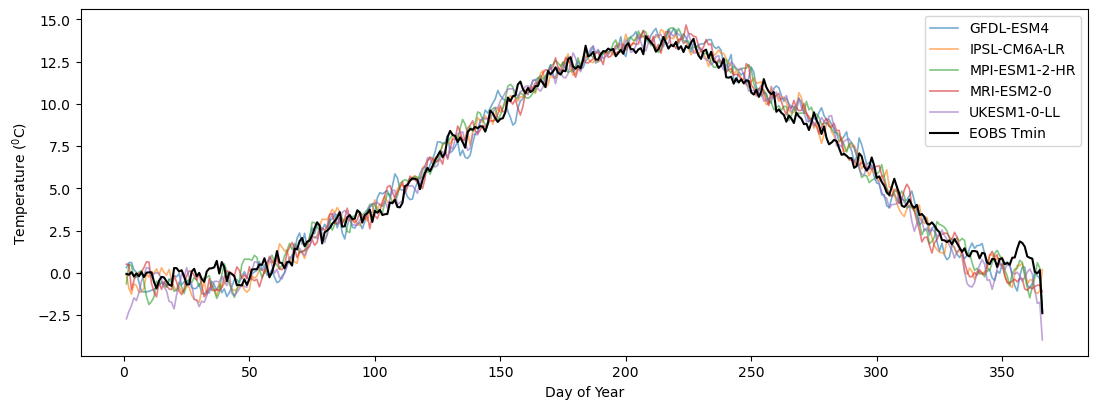

In [5]:

fig, ax = plt.subplots(figsize=(13, 4.5))


# Plotting the data
plt.plot(tasmin_df_.groupby(tasmin_df_.index.dayofyear).mean(), label=tasmin_df_.columns, alpha=0.6, lw=1.2)
plt.plot(tmin_df.groupby(tmin_df.index.dayofyear).mean(), color='k', label='EOBS Tmin')
#plt.plot(tmin_future_df_.groupby(tmax_future_df_.index.dayofyear).mean(), label=tmax_future_df_.columns, alpha=0.6, lw=1.2, c='orange')
plt.legend(loc='upper right', ncol=1)
plt.xlabel('Day of Year')
plt.ylabel('Temperature ($^0$C)')

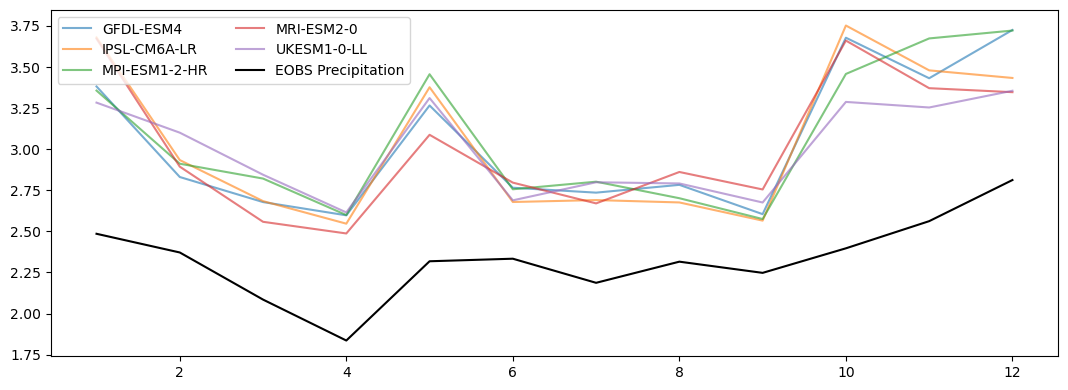

In [15]:
#Rainfall data

fig, ax = plt.subplots(figsize=(13, 4.5))

plt.plot(pr_df_.groupby(pr_df_.index.month).mean(), label=pr_df_.columns, alpha=0.6)
plt.plot(pr_df.groupby(pr_df.index.month).mean(), color='k', label='EOBS Precipitation')
plt.legend(loc='upper left', ncol=2)
  

#### Regridding ISIMIP to match observation resolution and extent

In [ ]:
model = 'IPSL-CM6A-LR'  # Example model

# 1) Load your observed reference (E-OBS) and your historical model run
obs = pr_EOBS['pre'].where(pr_EOBS['pre'].var(dim='time')> 0.001)  # Filter out nan data


sim_hist = pr_hist[(model, 'historical')]['pr'] * 86400  # Convert from kg m-2 s-1 to mm/day


sim_future = pr_future[(model, 'ssp370')]['pr'] * 86400  # Convert from kg m-2 s-1 to mm/day
sim_hist = sim_hist.assign_attrs(units="mm d-1", standard_name="precipitation_flux")

obs = obs.sel(time=slice('1971-01-01','2014-12-31'))  # Select the same time period as the historical simulation


#regrid with xesmf
regridder = xe.Regridder(sim_hist, obs, method='bilinear')

# Apply the regridder to the historical simulation
sim_hist_regrid = regridder(sim_hist)
# Apply the regridder to the future simulation
sim_future_regrid = regridder(sim_future)
sim_hist = sim_hist_regrid.assign_attrs(units="mm d-1", standard_name="precipitation_flux")
sim_future = sim_future_regrid.assign_attrs(units="mm d-1", standard_name="precipitation_flux")

#Make a mask where obs is not null
valid_mask = obs.notnull().any(dim="time")

#simhist where variance is not zero
sim_hist = sim_hist.where(sim_hist.var(dim='time') > 0.0001)
sim_hist = sim_hist.where(valid_mask)
#resample to daily
sim_hist = sim_hist.resample(time='1D').sum()  # Resample to daily data

#### Bias-correct with Empirical Quantile Mapping and Quantile Delta Mapping

In [80]:


hist_pr_eqm, fut_pr_eqm = pISIMIP.empirical_quantile_mapping(obs, sim_hist, sim_future, n_q=51, min_samples=10)

# with dask.config.set(**{'array.slicing.split_large_chunks': True}):
#     hist_pr_qdm, fut_pr_qdm =pISIMIP.quantile_delta_mapping(
#         obs, sim_hist, sim_future,
#         n_quantiles=251, min_valid=10, kind="*"
#     )

In [81]:
obs_n, hist_n = xr.align(obs, sim_hist, join="inner")
print("overlap timesteps:", obs_n.time.size)


overlap timesteps: 16071


#### Extract and Plot

In [85]:
maxlat, minlat, minlon, maxlon = 51.5, 47.5, 4.5, 6.5


obs_df = obs.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()
sim_hist_df = sim_hist.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_hist').resample('D').sum()
sim_fut_df = sim_future.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_fut').resample('D').sum()

hist_eqm_df = hist_pr_eqm.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_hist_bc').resample('D').sum()
fut_eqm_df = fut_pr_eqm.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name='pr_fut_bc').resample('D').sum()

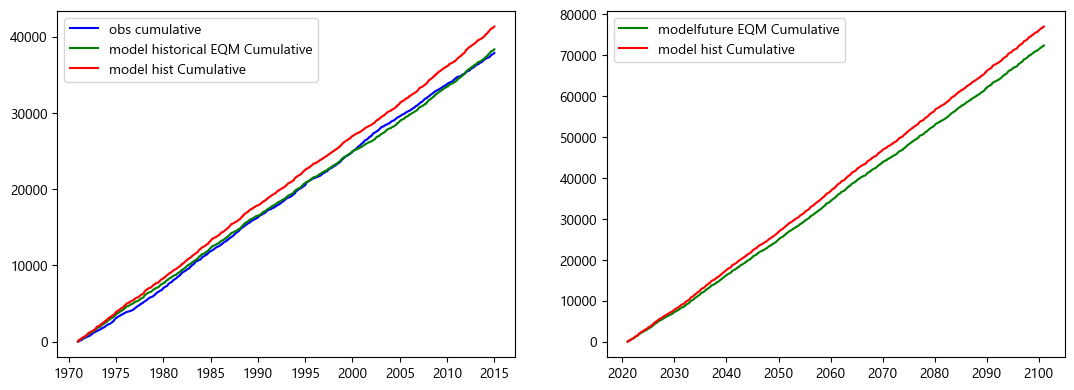

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

# Plotting the cumulative sums historical
axes[0].plot(np.cumsum(obs_df), c='b', label='obs cumulative')
axes[0].plot(np.cumsum(hist_eqm_df), c='g', label='model historical EQM Cumulative')
axes[0].plot(np.cumsum(sim_hist_df), c='r', label='model hist Cumulative')


#plot future EQM
axes[1].plot(np.cumsum(fut_eqm_df), c='g', label='modelfuture EQM Cumulative')
axes[1].plot(np.cumsum(sim_fut_df), c='r', label='model hist Cumulative')

axes[0].legend(loc='upper left', ncol=1)
axes[1].legend(loc='upper left', ncol=1)

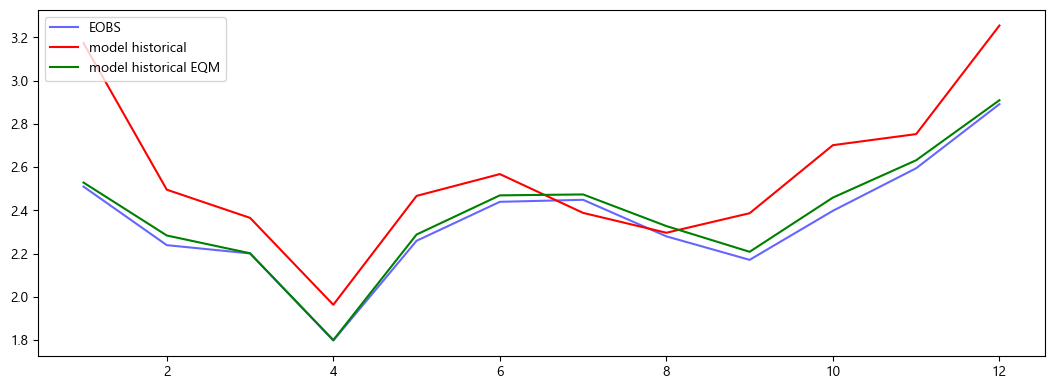

In [141]:
#plot 
fig, ax = plt.subplots(figsize=(13, 4.5))

plt.plot(obs_df.groupby(obs_df.index.month).mean(), alpha=0.6, label='EOBS', c='b')
plt.plot(sim_hist_df.groupby(sim_hist_df.index.month).mean(), color='r', label='model historical')
plt.plot(hist_eqm_df.groupby(hist_eqm_df.index.month).mean(), color='g', label='model historical EQM')
plt.legend(loc='upper left', ncol=1)

#### Apply downscaling to all models

In [246]:
from pathlib import Path

#regrid climate data to EOBS grid
# ----------------------------
# Settings you can tweak
# ----------------------------
METHOD = "bilinear"          # "bilinear" for rates; use "conservative_normed" for totals
VAR_NAME = "pr"              # precipitation variable key in your isimip_data
VAR_UNITS = "mm/day"         # CF-ish units string
VAR_STDNAME = "precipitation_flux"
long_name = "Regridded precipitation rate"
# ----------------------------


def regrid_ISIMIP_to_obs(isimip_data, obs, models, scenarios):  
    """
    Regrid ISIMIP data to EOBS grid and return a dictionary of model-scenario combinations.
    
    Parameters:
    isimip_data (dict): Dictionary containing ISIMIP data.
    obs (xarray.Dataset): EOBS dataset to regrid to.
    models (list): List of model names.
    scenarios (list): List of scenario names.
    
    Returns:
    dict: Dictionary with model-scenario combinations as keys and regridded data as values.
    """
        
    model_scenario_combos ={}

    for model in models:
        for scenario in scenarios:
                if (model, scenario, VAR_NAME) in isimip_data:

                    #change key to model_scenario_pr
                    name = f"{model}_{scenario}_{VAR_NAME}"

                    # Extract pr and convert precipitation flux from kg m-2 s-1 to mm/day
                    data = isimip_data[(model, scenario, VAR_NAME)]*86400  

                    #regrid the data to the EOBS grid with xesmf
                    #regrid with xesmf
                    data_grid = xe.Regridder(data, obs, method='bilinear')

                    # Apply the regridder to the historical simulation
                    data_regrid = data_grid(data)

                    #Make a mask where obs is not null
                    valid_mask = obs.notnull().any(dim="time")

                    #data where variance is not zero
                    #resample to daily
                    data_regrid = data_regrid.resample(time='1D').sum()
                    
                    data_regrid = data_regrid.where(data_regrid.var(dim='time') > 0.0001)
                    data_regrid = data_regrid.where(valid_mask)


                    #Define atributes
                        # 5) Attach useful attributes
                    attrs = dict(
                        units=VAR_UNITS,
                        standard_name=VAR_STDNAME,
                        long_name= long_name,
                        source="ISIMIP3b",
                        source_model=model,
                        source_scenario=scenario,
                        regrid_method=METHOD,
            )

                    #assign attributes
                    data_regrid = data_regrid.assign_attrs(**attrs)

                    #add to dictionary
                    model_scenario_combos[name] = data_regrid

    
    return model_scenario_combos


In [247]:

# Regrid ISIMIP data to EOBS grid
# -----------------------------------
isimip_regridded_pr = regrid_ISIMIP_to_obs(isimip_data, obs, models, scenarios)


#Get rid of empty rows and columns in the regridded data
# -----------------------------------
isimip_regridded_data = {}

#mask and drop empty rows/cols
for name, data in isimip_regridded_pr.items():

        #cells that are valid at least once over time
        valid = data.notnull().any("time")

        # mask and drop empty rows/cols
        data_valid = data.where(valid).dropna("lat", how="all").dropna("lon", how="all")

        isimip_regridded_data[name] = data_valid


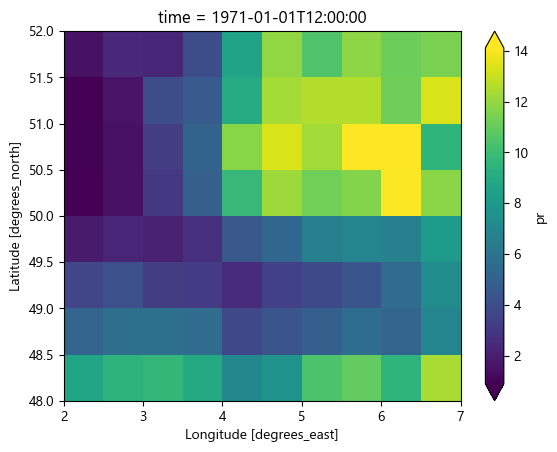

In [273]:
(isimip_data[('IPSL-CM6A-LR', 'historical', 'pr')]['pr'][0]*86400).plot(robust=True, cmap='viridis')

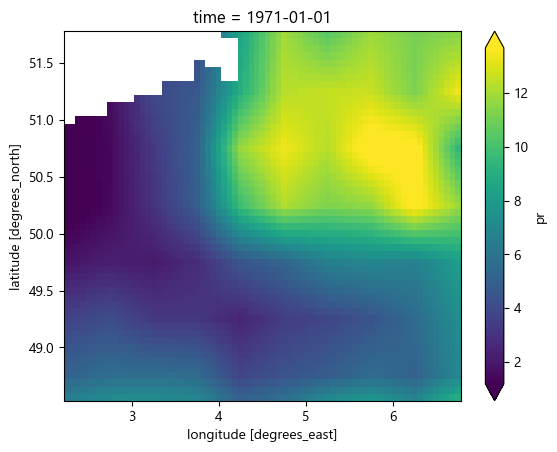

In [274]:
isimip_regridded_data['IPSL-CM6A-LR_historical_pr']['pr'][0].plot(robust=True, cmap='viridis')

In [249]:
### bias correct the regridded data
def bias_correct_ISIMIP(isimip_regridded, obs, models, future_scenarios, method, kind="*"):
    """
    Bias correct the regridded ISIMIP data using Empirical Quantile Mapping.
    
    Parameters:
    model_scenario_combos (dict): Dictionary with model-scenario combinations and regridded data.
    obs (xarray.DataArray): EOBS dataset to bias correct against.
    models (list): List of ISIMIP model names.
    scenarios (list): List of scenario names.
    method (str): Bias correction method, either 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping.
    kind (str): Kind of interpolation to use ("+": additive for temperature or "*": multiplicative for precipitation), default is "*".
    
    Returns:
    dict: Dictionary with bias-corrected data for each model-scenario combination.
    """
    
    # Create a dictionary to store the bias-corrected data
    model_scenario_combos_bc = {}

    for model in models:
            # extract historical and future data for the model
        hist_data = isimip_regridded.get(f"{model}_historical_{VAR_NAME}")[VAR_NAME]

        if hist_data is None: 
            print(f"[skip] missing {model} historical"); 
            continue

        for future in future_scenarios:

            fut_data = isimip_regridded.get(f"{model}_{future}_{VAR_NAME}")[VAR_NAME]

            if fut_data is None: 
                print(f"[skip] missing {model} {future}"); 
                continue
        #set obs to same extent as ISIMIP data
            obs = obs.sel(lat=slice(hist_data.lat.max(), hist_data.lat.min()),
                         lon=slice(hist_data.lon.min(), hist_data.lon.max()))

            if method == 'qdm':
                # Apply QDM bias correction
                hist_pr_bc, fut_pr_bc = pISIMIP.quantile_delta_mapping(obs, hist_data, fut_data, n_quantiles=251, min_valid=10, kind=kind)

            elif method == 'eqm':
                # Apply EQM bias correction
                hist_pr_bc, fut_pr_bc = pISIMIP.empirical_quantile_mapping(obs, hist_data, fut_data, n_q=51, min_samples=10)
            else:
                raise ValueError("Method must be either 'QDM' or 'EQM'.")


            hist_attrs = dict(
                    units=VAR_UNITS,
                    standard_name=VAR_STDNAME,
                    long_name="Regridded precipitation rate",
                    source_model=model,
                    source_scenario='historical',
                    bias_correction_method=method,
                    regrid_method=METHOD,
                    source="ISIMIP3b"
        )
            

            fut_attrs = dict(
                    units=VAR_UNITS,
                    standard_name=VAR_STDNAME,
                    long_name="Regridded precipitation rate",
                    source_model=model,
                    source_scenario=future,
                    bias_correction_method=method,
                    regrid_method=METHOD,
                    source="ISIMIP3b"
        )
            
            # Assign attributes to the bias-corrected data
            hist_pr_bc = hist_pr_bc.assign_attrs(**hist_attrs)
            fut_pr_bc = fut_pr_bc.assign_attrs(**fut_attrs)


            # Add the bias-corrected data to the dictionary
            model_scenario_combos_bc[f"{model}_historical_{method}"] = hist_pr_bc
            model_scenario_combos_bc[f"{model}_{future}_{method}"] = fut_pr_bc


    return model_scenario_combos_bc


In [250]:
#set obs to same extent as ISIMIP data


future_scenarios = ['ssp126', 'ssp370', 'ssp585']
method= 'qdm'  # Choose 'qdm' for Quantile Delta Mapping or 'eqm' for Empirical Quantile Mapping
kind = "*"  # Use "+" for temperature or "*" for precipitation
# Bias correct the regridded ISIMIP data
isimip_bc_EQM = bias_correct_ISIMIP(isimip_regridded_data, obs, models,
                                     future_scenarios, method=method, kind=kind)

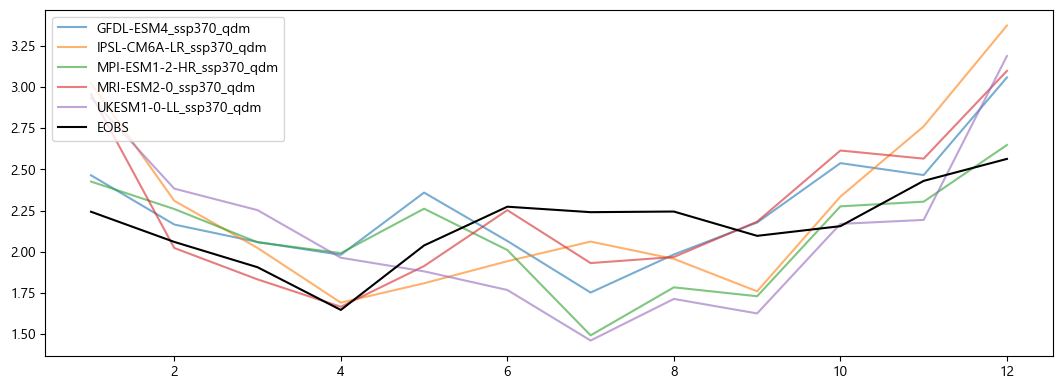

In [270]:
minlat, maxlat = isimip_bc_EQM['IPSL-CM6A-LR_historical_qdm']['lat'].min(), isimip_bc_EQM['IPSL-CM6A-LR_historical_qdm']['lat'].max()
minlon, maxlon = isimip_bc_EQM['IPSL-CM6A-LR_historical_qdm']['lon'].min(), isimip_bc_EQM['IPSL-CM6A-LR_historical_qdm']['lon'].max()

#select the historical bc data
isimip_bc_EQM_hist = {k: isimip_bc_EQM[k] for k in isimip_bc_EQM if 'ssp370' in k}
#select the future bc data
isimip_bc_EQM_future = {k: isimip_bc_EQM[k] for k in isimip_bc_EQM if 'ssp370' in k}

datadf=[]
keys = list(isimip_bc_EQM_hist.keys())
for key, data in isimip_bc_EQM_hist.items():
    data_df=data.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe(name=key).resample('D').sum()
    datadf.append(data_df)
# Combine all dataframes into a single dataframe
isimip_bc_EQM_hist = pd.concat(datadf, axis=1)
isimip_bc_EQM_hist.columns = keys

obs_df = obs.sel(lat=slice(maxlat, minlat), lon=slice(minlon, maxlon)).mean(dim=['lat', 'lon']).to_dataframe().resample('D').sum()

#plot the bias corrected data
fig, ax = plt.subplots(figsize=(13, 4.5))
plt.plot(isimip_bc_EQM_hist.groupby(isimip_bc_EQM_hist.index.month).mean(), alpha=0.6, label=keys)
plt.plot(obs_df.groupby(obs_df.index.month).mean(), color='k', label='EOBS')
plt.legend(loc='upper left', ncol=1)

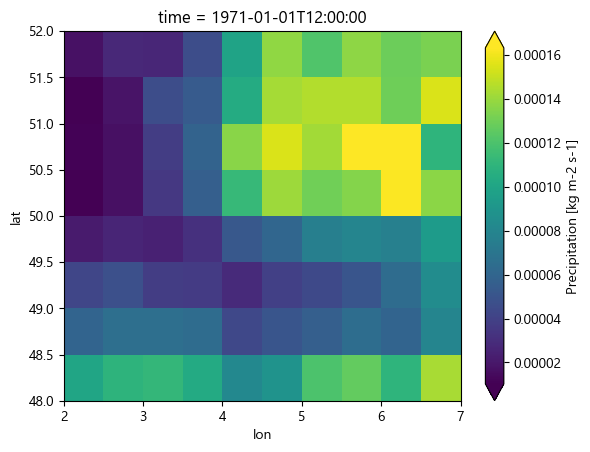

In [261]:
isimip_data[('IPSL-CM6A-LR', 'historical', 'pr')]['pr'][0].plot(robust=True, cmap='viridis')

In [253]:
#print monthly means
print("Monthly means of bias-corrected historical data:")
print(isimip_bc_EQM_hist.groupby(isimip_bc_EQM_hist.index.month).mean().mean())
print(obs_df.groupby(obs_df.index.month).mean().mean() )

Monthly means of bias-corrected historical data:
GFDL-ESM4_ssp126_qdm        2.521233
IPSL-CM6A-LR_ssp126_qdm     2.448464
MPI-ESM1-2-HR_ssp126_qdm    2.367173
MRI-ESM2-0_ssp126_qdm       2.399928
UKESM1-0-LL_ssp126_qdm      2.408260
dtype: float64
pre    2.352967
dtype: float32
